<a href="https://colab.research.google.com/github/hurricane195/Intro-to-Deep-Learning/blob/Final-Project/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Using modified example of Roboflow's DETR Mohamed Radwan model "Car Detection Dataset": https://github.com/mhmdrdwn/car/blob/main/notebooks/selfdrivingcardataset.ipynb
#Using modified Udacity dataset "Self-Driving Cars" uploaded to Roboflow's platform in order to annotate and modify dataset

In [ ]:
%%capture

import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib.image as mpimg

import cv2

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from fastai.vision.all import *

import json
import glob


from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
#!cat ./README.dataset.txt

file_path = '/content/drive/MyDrive/Colab Notebooks/Intro to Neural Networks/Project/Datasets/coco/Self Driving Car.v3-fixed-small.coco - Experimental - 50/README.dataset.txt'

# Read the file into your notebook.
with open(file_path, 'r') as f:
    data = f.read()


!find "/content/drive/MyDrive/Colab Notebooks/Intro to Neural Networks/Project/Datasets/coco/Self Driving Car.v3-fixed-small.coco - Experimental - 50/export" -type f | perl -ne 'print $1 if m/\.([^.\/]+)$/' | sort -u

!ls -R "/content/drive/MyDrive/Colab Notebooks/Intro to Neural Networks/Project/Datasets/coco/Self Driving Car.v3-fixed-small.coco - Experimental - 50/export" | grep "\.json$"

# Path to the JSON file in your Google Drive
json_file_path = '/content/drive/MyDrive/Colab Notebooks/Intro to Neural Networks/Project/Datasets/coco/Self Driving Car.v3-fixed-small.coco - Experimental - 50/export/_annotations.coco.json'

# Load JSON file
with open(json_file_path) as f:
    annotations = json.load(f)

# Extract category names and IDs
category_dict = {}
for cat in annotations['categories']:
    category_dict[cat['id']] = cat['name']

category_dict

1
avi
bat
categories
cff
cfg
clang-format
cmake
conf
cpp
css
cu
gitattributes
git-blame-ignore-revs
gitignore
gradle
h
html
idx
in
ini
jar
java
jpg
json
m
md
mm
mp4
pbxproj
pkl
plist
png
podspec
properties
pt
py
pyc
rst
sample
sh
storyboard
svg
tiff
toml
txt
xcworkspacedata
xml
yaml
yml
_annotations.coco.json
imagenet_class_index.json
instances.json
Contents.json
Contents.json
Contents.json
optests_failures_dict.json
imagenet_class_index.json
instances.json
Contents.json
Contents.json
Contents.json
optests_failures_dict.json


{0: 'obstacles',
 1: 'biker',
 2: 'car',
 3: 'pedestrian',
 4: 'trafficLight',
 5: 'trafficLight-Green',
 6: 'trafficLight-GreenLeft',
 7: 'trafficLight-Red',
 8: 'trafficLight-RedLeft',
 9: 'trafficLight-Yellow',
 10: 'trafficLight-YellowLeft',
 11: 'truck'}

1478020481198610989_jpg.rf.xFKPeb9uPkROnm1ZMBUJ.jpg
1478020480697757042_jpg.rf.H95PG9EVAaDuawz3hz7y.jpg
1478020481697866949_jpg.rf.6a600c01bc7f22e150a1a4a8560f39e9.jpg
1478020961714669341_jpg.rf.9220493d6dbb2a3b91603ea79f615462.jpg
uint8
(512, 512, 3)


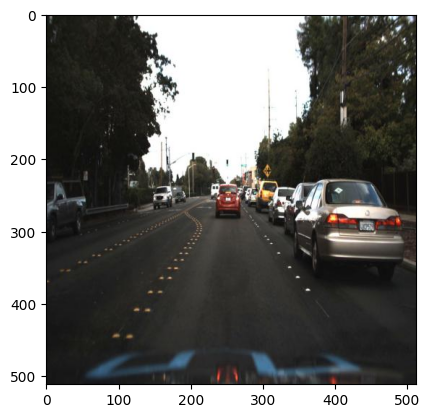

In [ ]:
!ls -U '/content/drive/MyDrive/Colab Notebooks/Intro to Neural Networks/Project/Datasets/coco/Self Driving Car.v3-fixed-small.coco - Experimental - 50/export' | head -n 4

# Path to the image file in your Google Drive
image_file_path = '/content/drive/MyDrive/Colab Notebooks/Intro to Neural Networks/Project/Datasets/coco/Self Driving Car.v3-fixed-small.coco - Experimental - 50/export/1478020961714669341_jpg.rf.9220493d6dbb2a3b91603ea79f615462.jpg'

# Read the image
plt_image = mpimg.imread(image_file_path)

# Output image properties
print(plt_image.dtype)
print(plt_image.shape)

# Display the image
plt.imshow(plt_image)
plt.show()

uint8
(512, 512, 3)


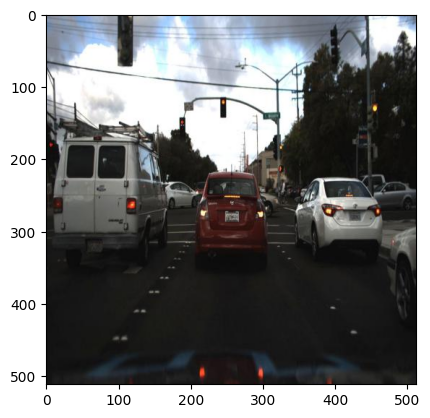

In [ ]:
# Path to the image file in your Google Drive
image_file_path = '/content/drive/MyDrive/Colab Notebooks/Intro to Neural Networks/Project/Datasets/coco/Self Driving Car.v3-fixed-small.coco - Experimental - 50/export/1478020972214734428_jpg.rf.ff250f8f774277338fa99bb920104b72.jpg'

# Read the image
plt_image = mpimg.imread(image_file_path)

# Output image properties
print(plt_image.dtype)
print(plt_image.shape)

# Display the image
plt.imshow(plt_image)
plt.show()

In [ ]:
class SelfDrivingCarDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, annotations_path, std=False):
        super(SelfDrivingCarDataset, self).__init__()
        self.images_path = glob.glob(images_path + "*.jpg")
        self.std = std
        with open(annotations_path) as f:
            self.annotations = json.load(f)

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        file_path = self.images_path[idx]
        file_name = file_path.split("/")[-1]
        img_id = None
        for img_name in self.annotations['images']:
            if img_name['file_name'] == file_name:
                img_id = img_name['id']
                break

        bbox, areas, iscrowd, labels = [], [], [], []
        for box in self.annotations['annotations']:
            if box['image_id'] == img_id:
                bbox.append(box['bbox'])
                areas.append(box['area'])
                iscrowd.append(box['iscrowd'])
                labels.append(box['category_id'])

        img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        bbox = np.array(bbox)
        areas = np.array(areas)
        iscrowd = np.array(iscrowd)
        labels = np.array(labels)

        if len(bbox) !=0:
            bbox[:, 2] = bbox[:, 0] + bbox[:, 2]
            bbox[:, 3] = bbox[:, 1] + bbox[:, 3]
            bbox = torch.from_numpy(bbox)
            bbox = torch.as_tensor(bbox, dtype=torch.int64)
        else:
            bbox = torch.zeros((0, 4), dtype=torch.float32)


        if self.std:
            img = img/255.0

        target = {}

        labels = torch.tensor(labels, dtype=torch.int64)
        iscrowd = torch.tensor(iscrowd, dtype=torch.int64)
        image_id = torch.tensor([idx])
        areas = torch.as_tensor(areas.astype(float), dtype=torch.double)  # Replaced np.float with float

        target["boxes"] = bbox
        target["labels"] = labels
        target["area"] = areas
        target["iscrowd"] = iscrowd
        target["image_id"] = image_id

        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img)

        return img, target

torch.Size([512, 512, 3]) tensor([[ 29, 243, 123, 323],
        [179, 241, 204, 270],
        [269, 238, 283, 258],
        [295, 245, 307, 282],
        [303, 247, 344, 294],
        [370, 241, 502, 349]]) tensor([2, 2, 2, 2, 2, 2])


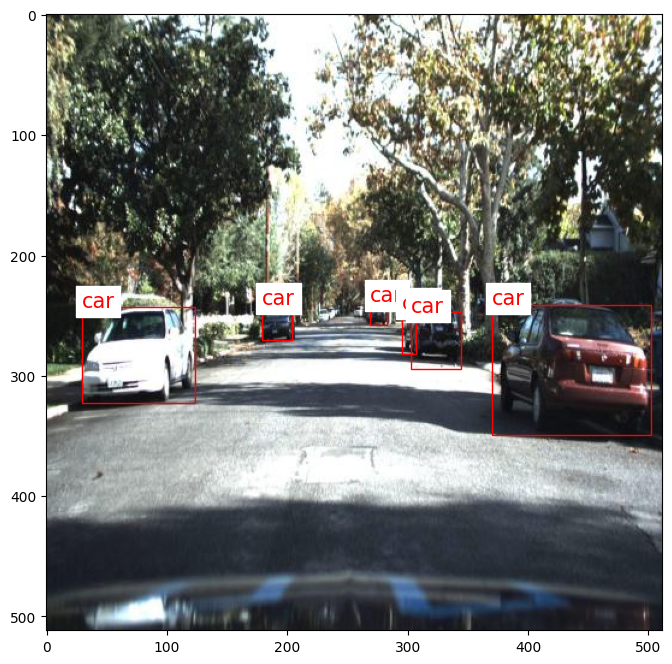

In [ ]:
# Specify paths to images and annotations
images_path = '/content/drive/MyDrive/Colab Notebooks/Intro to Neural Networks/Project/Datasets/coco/Self Driving Car.v3-fixed-small.coco - Experimental - 50/export/'
annotations_path = '/content/drive/MyDrive/Colab Notebooks/Intro to Neural Networks/Project/Datasets/coco/Self Driving Car.v3-fixed-small.coco - Experimental - 50/export/_annotations.coco.json'

# Instantiate the dataset
dataset = SelfDrivingCarDataset(images_path, annotations_path)

# Example usage of dataset
img, target = dataset.__getitem__(30)

img = img.permute(1, 2, 0)  # Reorder dimensions for visualization
img = img.type(torch.uint8)  # Convert image data type to uint8
print(img.shape, target["boxes"], target["labels"])

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(img)
for lab, lab_name in zip(target['boxes'], target["labels"]):
    rect = patches.Rectangle((lab[0], lab[1]), lab[2] - lab[0], lab[3] - lab[1],
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.annotate(category_dict[int(lab_name)], (lab[0], lab[1]),
                color='red', fontsize=15, backgroundcolor="w")
    ax.add_patch(rect)

plt.show()

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Define paths to images and annotations
images_path = "/content/drive/MyDrive/Colab Notebooks/Intro to Neural Networks/Project/Datasets/coco/Self Driving Car.v3-fixed-small.coco - Experimental - 50/export/"
annotations_path = "/content/drive/MyDrive/Colab Notebooks/Intro to Neural Networks/Project/Datasets/coco/Self Driving Car.v3-fixed-small.coco - Experimental - 50/export/_annotations.coco.json"

# Instantiate the dataset
dataset = SelfDrivingCarDataset(images_path, annotations_path, std=True)

# Split the dataset into train, validation, and test sets
total_size = len(dataset)
train_size = int(0.7 * total_size)  # 70% train
val_size = int(0.15 * total_size)   # 15% validation
test_size = total_size - train_size - val_size  # Remaining for test

# Use torch.utils.data.random_split to split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Print sizes of subsets
print("Size of train data:", len(train_dataset))
print("Size of val data:", len(val_dataset))
print("Size of test data:", len(test_dataset))

Size of train data: 35
Size of val data: 7
Size of test data: 8


In [ ]:
# Define data loaders
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=0,
    collate_fn=collate_fn
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=False, num_workers=0,
    collate_fn=collate_fn
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=collate_fn
)


In [ ]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print("Device:", device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print("Device:", device)

Device: cuda NVIDIA A100-SXM4-40GB


In [ ]:
%%sh
if [ ! -d "output/vision" ]; then
    git clone https://github.com/pytorch/vision.git output/vision
else
    echo "output/vision already cloned"
fi

Cloning into 'output/vision'...


In [ ]:
%%capture
!pip3 install pycocotools
!pip3 install -U scikit-image
!pip3 install -U cython

In [ ]:
import torchvision
num_classes = 13
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
fasterRCNN_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = fasterRCNN_model.roi_heads.box_predictor.cls_score.in_features
fasterRCNN_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 179MB/s]


In [ ]:
class LossAverager:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
%%sh
if [ ! -d "output/vision" ]; then
    git clone https://github.com/pytorch/vision.git output/vision
else
    echo "output/vision already cloned"
fi

output/vision already cloned


In [ ]:
!cp output/vision/references/detection/utils.py .
!cp output/vision/references/detection/transforms.py .
!cp output/vision/references/detection/coco_eval.py .
!cp output/vision/references/detection/engine.py .
!cp output/vision/references/detection/coco_utils.py .

Epoch 1/100


  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 9/9 [00:24<00:00,  2.73s/it]


Train loss: 3.4452452586590914
Val loss: 2.9273467601714844
Validation accuracy: 0.06142857142857143
Epoch 2/100


100%|██████████| 9/9 [00:06<00:00,  1.49it/s]


Train loss: 2.2643989282686685
Val loss: 1.4532923254941064
Validation accuracy: 0.13031914893617022
Epoch 3/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 1.2284780952061318
Val loss: 1.2966290676162904
Validation accuracy: 0.10865191146881288
Epoch 4/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 1.0528682867967094
Val loss: 1.1734400470932553
Validation accuracy: 0.13078470824949698
Epoch 5/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.8718503765637606
Val loss: 1.0387424196267647
Validation accuracy: 0.1642156862745098
Epoch 6/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.7633000306770582
Val loss: 0.945094566677116
Validation accuracy: 0.18306636155606407
Epoch 7/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.6436271816301355
Val loss: 0.8816036642584338
Validation accuracy: 0.2169576059850374
Epoch 8/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.5582542144745646
Val loss: 0.8016217156050883
Validation accuracy: 0.2716417910447761
Epoch 9/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.5110487811042298
Val loss: 0.7462481047479453
Validation accuracy: 0.29896907216494845
Epoch 10/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.48548865157412047
Val loss: 0.7343344874187664
Validation accuracy: 0.2976588628762542
Epoch 11/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.46636088009713916
Val loss: 0.7015453345011137
Validation accuracy: 0.29457364341085274
Epoch 12/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.4283297081006476
Val loss: 0.7049619574404362
Validation accuracy: 0.3463035019455253
Epoch 13/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.41413370408471367
Val loss: 0.6204917987999458
Validation accuracy: 0.2950191570881226
Epoch 14/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.36211700742879477
Val loss: 0.5914453072221441
Validation accuracy: 0.40298507462686567
Epoch 15/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.3362192381430268
Val loss: 0.5785979670300473
Validation accuracy: 0.3829787234042553
Epoch 16/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.3227812957429903
Val loss: 0.6175245514379076
Validation accuracy: 0.4294478527607362
Epoch 17/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.314658256139423
Val loss: 0.5574455366726947
Validation accuracy: 0.43506493506493504
Epoch 18/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.2971377966219941
Val loss: 0.5352663117190452
Validation accuracy: 0.496551724137931
Epoch 19/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.2693839854756028
Val loss: 0.553488832184278
Validation accuracy: 0.5275590551181102
Epoch 20/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.2826910971942579
Val loss: 0.4891265548162376
Validation accuracy: 0.5214285714285715
Epoch 21/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.25431709215030285
Val loss: 0.5376696929471091
Validation accuracy: 0.52
Epoch 22/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.25289511514830626
Val loss: 0.5395508006452499
Validation accuracy: 0.5803571428571429
Epoch 23/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.24847764282749735
Val loss: 0.49914070919404896
Validation accuracy: 0.5892857142857143
Epoch 24/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.23567234491968828
Val loss: 0.4887262260788497
Validation accuracy: 0.6
Epoch 25/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.23141421513749633
Val loss: 0.5008849089212803
Validation accuracy: 0.5818181818181818
Epoch 26/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.2141123294680202
Val loss: 0.48952588347004644
Validation accuracy: 0.5688073394495413
Epoch 27/100


100%|██████████| 9/9 [00:05<00:00,  1.62it/s]


Train loss: 0.2082383358655991
Val loss: 0.5046292142867652
Validation accuracy: 0.5865384615384616
Epoch 28/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.20320480568898674
Val loss: 0.4980996257305516
Validation accuracy: 0.65625
Epoch 29/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.2190918203621331
Val loss: 0.483004019575107
Validation accuracy: 0.5943396226415094
Epoch 30/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.19194726727464906
Val loss: 0.4841943813941118
Validation accuracy: 0.6631578947368421
Epoch 31/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.18954849979461263
Val loss: 0.42324040958901704
Validation accuracy: 0.6138613861386139
Epoch 32/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.18700920716675057
Val loss: 0.4834779767915398
Validation accuracy: 0.5865384615384616
Epoch 33/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.1847575563074342
Val loss: 0.45223534524864545
Validation accuracy: 0.6224489795918368
Epoch 34/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.17919711624430082
Val loss: 0.4722096387876649
Validation accuracy: 0.6444444444444445
Epoch 35/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.19315879384471862
Val loss: 0.48345227768720483
Validation accuracy: 0.6122448979591837
Epoch 36/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.187028998444278
Val loss: 0.46587111446454527
Validation accuracy: 0.6185567010309279
Epoch 37/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.1933545565744896
Val loss: 0.4713806910136363
Validation accuracy: 0.5673076923076923
Epoch 38/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.18446685908825672
Val loss: 0.4948489030251566
Validation accuracy: 0.6039603960396039
Epoch 39/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.1732344942619742
Val loss: 0.4999163726146767
Validation accuracy: 0.6145833333333334
Epoch 40/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.16965207323770395
Val loss: 0.4622439692755124
Validation accuracy: 0.6224489795918368
Epoch 41/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.14767608841273147
Val loss: 0.47115331941332217
Validation accuracy: 0.6896551724137931
Epoch 42/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.1480761072552623
Val loss: 0.443815648436974
Validation accuracy: 0.6521739130434783
Epoch 43/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.14095581040277583
Val loss: 0.44906861634923473
Validation accuracy: 0.6304347826086957
Epoch 44/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.14526444503484215
Val loss: 0.4519199682180723
Validation accuracy: 0.6666666666666666
Epoch 45/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.15505759058193266
Val loss: 0.4477466869668578
Validation accuracy: 0.7228915662650602
Epoch 46/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.16529942288915592
Val loss: 0.45571897346762036
Validation accuracy: 0.6413043478260869
Epoch 47/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.16111736604004548
Val loss: 0.48723436907543727
Validation accuracy: 0.6896551724137931
Epoch 48/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.15821615722622154
Val loss: 0.44566184955251004
Validation accuracy: 0.6590909090909091
Epoch 49/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.15701922807565719
Val loss: 0.45585263385164504
Validation accuracy: 0.631578947368421
Epoch 50/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.15123727820974703
Val loss: 0.4978015935743958
Validation accuracy: 0.6413043478260869
Epoch 51/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.150716522862476
Val loss: 0.45631221636345454
Validation accuracy: 0.7058823529411765
Epoch 52/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.13479494559893437
Val loss: 0.4342496524175819
Validation accuracy: 0.6741573033707865
Epoch 53/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.13159686931665499
Val loss: 0.4484731531996606
Validation accuracy: 0.7283950617283951
Epoch 54/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.13311209112531303
Val loss: 0.44283034490225903
Validation accuracy: 0.7468354430379747
Epoch 55/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.11890493537505584
Val loss: 0.4464096963738089
Validation accuracy: 0.7317073170731707
Epoch 56/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.12195379559697808
Val loss: 0.4661349193943752
Validation accuracy: 0.7468354430379747
Epoch 57/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.11712478799805923
Val loss: 0.4504750118153198
Validation accuracy: 0.6976744186046512
Epoch 58/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.1206402385150024
Val loss: 0.44026371130828973
Validation accuracy: 0.6853932584269663
Epoch 59/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.12899198389641764
Val loss: 0.4182720726802793
Validation accuracy: 0.7341772151898734
Epoch 60/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.10946032728039715
Val loss: 0.43192270824705675
Validation accuracy: 0.7435897435897436
Epoch 61/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.11585729953926242
Val loss: 0.4222691289579296
Validation accuracy: 0.7407407407407407
Epoch 62/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.11394582447002344
Val loss: 0.469265145152828
Validation accuracy: 0.7435897435897436
Epoch 63/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.10863329978465189
Val loss: 0.45733318793165195
Validation accuracy: 0.7468354430379747
Epoch 64/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.11394246743670214
Val loss: 0.461622054597197
Validation accuracy: 0.7073170731707317
Epoch 65/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.11613900394092214
Val loss: 0.4535310723449018
Validation accuracy: 0.7195121951219512
Epoch 66/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.10681204644163501
Val loss: 0.45301724409903316
Validation accuracy: 0.7564102564102564
Epoch 67/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.11042063707489948
Val loss: 0.4382866467290533
Validation accuracy: 0.7195121951219512
Epoch 68/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.11168678544686099
Val loss: 0.4416398524886507
Validation accuracy: 0.8082191780821918
Epoch 69/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.11180706574237506
Val loss: 0.437926749615359
Validation accuracy: 0.7866666666666666
Epoch 70/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.1127510285090818
Val loss: 0.44700536912168926
Validation accuracy: 0.7375
Epoch 71/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.12080059209527536
Val loss: 0.45348522197204133
Validation accuracy: 0.8169014084507042
Epoch 72/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.1097212391846718
Val loss: 0.41647436898187656
Validation accuracy: 0.759493670886076
Epoch 73/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.1038110915272669
Val loss: 0.44868369262513125
Validation accuracy: 0.7945205479452054
Epoch 74/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.10937715360022489
Val loss: 0.4378846748544207
Validation accuracy: 0.7631578947368421
Epoch 75/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.11171983099248176
Val loss: 0.4426570878293368
Validation accuracy: 0.8108108108108109
Epoch 76/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.1065032189598564
Val loss: 0.4239627968874288
Validation accuracy: 0.7564102564102564
Epoch 77/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.10846691063616203
Val loss: 0.43450116742409906
Validation accuracy: 0.7733333333333333
Epoch 78/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.11261640746369006
Val loss: 0.4598499821403211
Validation accuracy: 0.7532467532467533
Epoch 79/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.10559884835707908
Val loss: 0.4545982226008595
Validation accuracy: 0.7733333333333333
Epoch 80/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.10358095813605525
Val loss: 0.4582057511978284
Validation accuracy: 0.7341772151898734
Epoch 81/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.10027738277196134
Val loss: 0.4488452039306061
Validation accuracy: 0.7341772151898734
Epoch 82/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.1091040052835631
Val loss: 0.45013223552490994
Validation accuracy: 0.7972972972972973
Epoch 83/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.09964806508647779
Val loss: 0.42711601839017327
Validation accuracy: 0.7763157894736842
Epoch 84/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.10437148278956072
Val loss: 0.4617997356526162
Validation accuracy: 0.7532467532467533
Epoch 85/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.10470236780399512
Val loss: 0.4342945996268089
Validation accuracy: 0.7435897435897436
Epoch 86/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.09366896245855655
Val loss: 0.4445940427298202
Validation accuracy: 0.7468354430379747
Epoch 87/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.09658902776894579
Val loss: 0.4277569392716693
Validation accuracy: 0.8055555555555556
Epoch 88/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.0972018587423306
Val loss: 0.43847102615397815
Validation accuracy: 0.8055555555555556
Epoch 89/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.08671946395787301
Val loss: 0.43603450910138
Validation accuracy: 0.8529411764705882
Epoch 90/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.09126873799384623
Val loss: 0.46963182358948163
Validation accuracy: 0.8285714285714286
Epoch 91/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.0967283623748954
Val loss: 0.4582790259662925
Validation accuracy: 0.7945205479452054
Epoch 92/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.10397575834919665
Val loss: 0.44184227944305166
Validation accuracy: 0.7837837837837838
Epoch 93/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.09492665652317873
Val loss: 0.4554137185482832
Validation accuracy: 0.7837837837837838
Epoch 94/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.09483903613044231
Val loss: 0.4750624946430886
Validation accuracy: 0.8082191780821918
Epoch 95/100


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Train loss: 0.10640077968950412
Val loss: 0.43629709601337296
Validation accuracy: 0.7564102564102564
Epoch 96/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.11107595964152421
Val loss: 0.4320924695075741
Validation accuracy: 0.7733333333333333
Epoch 97/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.09967371981366038
Val loss: 0.435942778972608
Validation accuracy: 0.7662337662337663
Epoch 98/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.09225334171259254
Val loss: 0.45177033046870924
Validation accuracy: 0.7763157894736842
Epoch 99/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.08338933455792073
Val loss: 0.4286583701408981
Validation accuracy: 0.7837837837837838
Epoch 100/100


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Train loss: 0.08020442803122428
Val loss: 0.44742076173389217
Validation accuracy: 0.8428571428571429


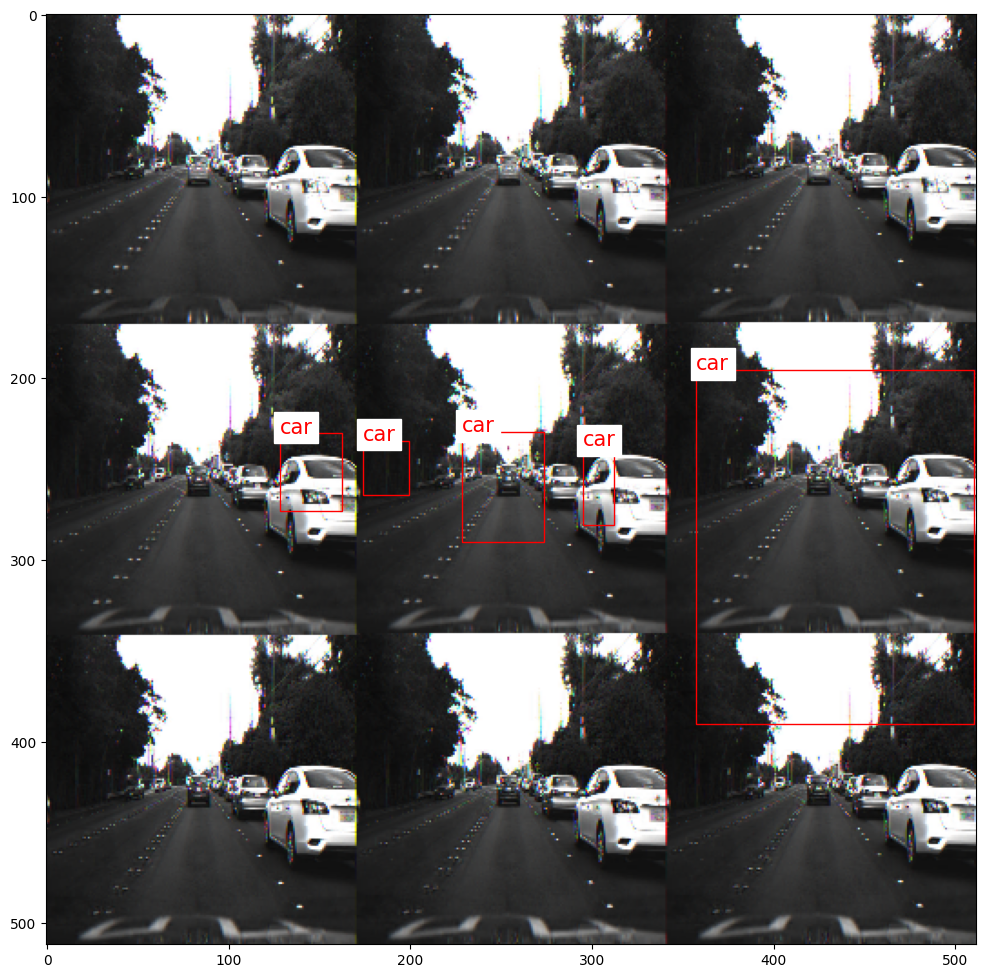

In [ ]:
from engine import train_one_epoch, evaluate
import time

loss_hist = LossAverager()

EPOCHS = 100

fasterRCNN_model.double()
fasterRCNN_model.to(device)

params = [p for p in fasterRCNN_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.00005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

def calculate_accuracy(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_predicted = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = torch.stack(images).double().to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes']
                pred_labels = output['labels']

                true_boxes = target['boxes']
                true_labels = target['labels']

                total_predicted += len(pred_labels)

                detected_indices = set()  # Track indices of detected objects to avoid counting duplicates
                for pred_box, pred_label in zip(pred_boxes, pred_labels):
                    for true_box, true_label in zip(true_boxes, true_labels):
                        iou = torchvision.ops.box_iou(pred_box.unsqueeze(0), true_box.unsqueeze(0)).item()
                        if iou > 0.5 and pred_label == true_label and true_label not in detected_indices:
                            total_correct += 1
                            detected_indices.add(true_label)  # Mark the true object as detected to avoid duplicates
                            break  # Only count once per predicted box

    accuracy = total_correct / total_predicted if total_predicted != 0 else 0  # Handle division by zero
    return accuracy


for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    tick = time.time()
    fasterRCNN_model.train()
    loss_hist.reset()

    for images, targets in tqdm(train_dataloader):

        images = torch.stack(images).double().to(device)  # Convert images to double precision
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        bs = images.shape[0]
        loss_dict = fasterRCNN_model(images, targets)

        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        loss_hist.update(lossValue, bs)

        optimizer.zero_grad()
        totalLoss.backward()
        optimizer.step()
        lr_scheduler.step(totalLoss)

    print(f"Train loss: {loss_hist.avg}")
    loss_hist.reset()

    for images, targets in val_dataloader:
        images = torch.stack(images).double().to(device)  # Convert images to double precision
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = fasterRCNN_model(images, targets)
        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        loss_hist.update(lossValue, bs)

    print(f"Val loss: {loss_hist.avg}")

    val_accuracy = calculate_accuracy(fasterRCNN_model, val_dataloader, device)
    print(f"Validation accuracy: {val_accuracy}")

fasterRCNN_model.eval()

def sample_prediction():
    fasterRCNN_model.eval()
    cpu = torch.device("cpu")
    fasterRCNN_model.to(cpu)
    sample_image = test_dataset.__getitem__(2)[0]
    groundtruth_boxes = test_dataset.__getitem__(2)[1]["boxes"]
    sample_image = torch.unsqueeze(sample_image, 0)

    # Convert the input image to double precision
    sample_image = sample_image.double().to(cpu)

    outputs = fasterRCNN_model(sample_image)

    if outputs is None or len(outputs) == 0:  # Check if outputs is empty
        print("No detections found.")
        return None, None, None, None, groundtruth_boxes

    outputs = [{k: v for k, v in t.items()} for t in outputs]

    # Check if boxes are empty
    if outputs[0]["boxes"] is None or len(outputs[0]["boxes"]) == 0:

        print("No bounding boxes found.")
        return None, None, None, None, groundtruth_boxes

    boxes = outputs[0]["boxes"].detach().numpy()
    scores = outputs[0]["scores"].detach().numpy()
    labels = outputs[0]["labels"].detach().numpy()
    sample_image = sample_image.reshape(sample_image.shape[2], sample_image.shape[3], 3)
    return sample_image, boxes, scores, labels, groundtruth_boxes

sample_image, boxes, scores, labels, groundtruth_boxes = sample_prediction()


def nms():
    """NMS iteratively removes lower scoring boxes which have an IoU
    greater than iou_threshold with another (higher scoring) box.
    """
    iou = 0.99
    iou_threshold = 1 - iou
    NMS = torchvision.ops.nms(torch.tensor(boxes), torch.tensor(scores), iou_threshold)
    best_boxes, best_scores, best_labels = [], [], []
    for nms in NMS:
        best_boxes.append(boxes[nms])
        best_scores.append(scores[nms])
        best_labels.append(labels[nms])
    return best_boxes, best_scores, best_labels

best_boxes, best_scores, best_labels = nms()


fig, ax = plt.subplots(figsize=(12,18))
ax.imshow(sample_image)
for box, score, label in zip(best_boxes, best_scores, best_labels):
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.annotate(category_dict[label],(box[0], box[1]), color='red', fontsize=15,backgroundcolor="w")
    ax.add_patch(rect)
plt.show()